In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [2]:
name_dataset = 'economic'

### load data

In [3]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(71951, 7)
CPU times: user 21.8 s, sys: 270 ms, total: 22 s
Wall time: 23.2 s


In [4]:
df = df[df.text!='text']
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/imf/,NaN,Россия,МВФ требует от Центробанка закрыть зарубежные ...,Получение финансовой помощи от МВФ станет для ...,Экономика
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/nds/,NaN,Россия,"Госдума изменила ставки НДС, несмотря на возра...","На своем пятничном заседании Госдума, несмотря...",Экономика


### preprocess

* get dates

In [5]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 412 ms, sys: 15.4 ms, total: 428 ms
Wall time: 459 ms


<unknown>:2: DeprecationWarning: invalid escape sequence \d


* clean text

In [6]:
import preprocessing_tools as pr

In [7]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 19.2 s, sys: 163 ms, total: 19.3 s
Wall time: 20.5 s


In [8]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/imf/,NaN,Россия,МВФ требует от Центробанка закрыть зарубежные ...,получение финансовой помощи от мвф станет для ...,Экономика,"[(1999, 10, 01)]",1999,10
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/nds/,NaN,Россия,"Госдума изменила ставки НДС, несмотря на возра...",на своем пятничном заседании госдума несмотря ...,Экономика,"[(1999, 10, 01)]",1999,10


* cleanedNames

In [9]:
from cleanedNames import KeyProc
cn = KeyProc()

In [10]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 3min 11s, sys: 36.5 ms, total: 3min 11s
Wall time: 3min 25s


* lemmatization

In [11]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 4min 35s, sys: 488 ms, total: 4min 36s
Wall time: 4min 52s


* add docID

In [12]:
df['docID'] = list(range(df.shape[0]))

In [13]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[получение, финансовый, помощь, мвф, стать, ро..."
1,1,1999,10,"[свой, пятничный, заседание, госдума, несмотря..."


In [14]:
print(df.shape)
df.isnull().sum()

(71951, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [15]:
df.year.min()

1999

## model

* prepare

In [16]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 1.44 s, sys: 180 ms, total: 1.62 s
Wall time: 1.75 s


In [17]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [18]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

create folder...

artm.BatchVectorizer(data_path="data/batches/economic", num_batches=72)
CPU times: user 47 s, sys: 1 s, total: 48 s
Wall time: 26.4 s


In [19]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [20]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=6c308b38-4b08-43a8-a216-7ae379ca3c87, num_entries=22229)

In [21]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [ ]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #

#topic 2.........
	SparsityThetaScore: 0.1473085880279541
	SparsityPhiScore: 0.2832336127758026
	PerplexityScore: 3557.615966796875
	time: 0:06:17.897376
#topic 3.........
	SparsityThetaScore: 0.267848938703537
	SparsityPhiScore: 0.3959992229938507
	PerplexityScore: 3185.9775390625
	time: 0:06:33.780013
#topic 4.........
	SparsityThetaScore: 0.3526427745819092
	SparsityPhiScore: 0.48169058561325073
	PerplexityScore: 2944.277099609375
	time: 0:07:04.638138
#topic 5.........
	SparsityThetaScore: 0.42198440432548523
	SparsityPhiScore: 0.5441630482673645
	PerplexityScore: 2742.6923828125
	time: 0:08:24.699401
#topic 6.........
	SparsityThetaScore: 0.4615872800350189
	SparsityPhiScore: 0.6017889380455017
	PerplexityScore: 2616.28076171875
	time: 0:09:07.455534
#topic 7.........
	SparsityThetaScore: 0.50811368227005
	SparsityPhiScore: 0.6367036700248718
	PerplexityScore: 2535.360107421875
	time: 0:10:24.139186
#topic 8.........
	SparsityThetaScore: 0.5631905794143677
	SparsityPhiScore: 0.651

In [31]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

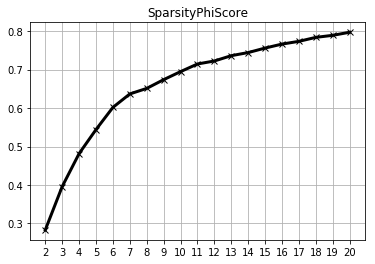

In [24]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [25]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [26]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.2: 1, 0.3: 1, 0.4: 1, 0.5: 1, 0.6: 5, 0.7: 10}

Text(0.5, 1.0, 'SparsityThetaScore')

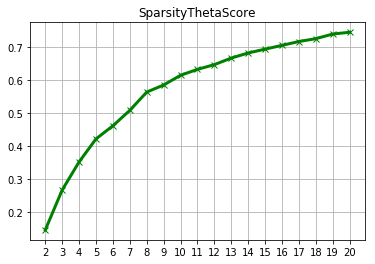

In [27]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [28]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [29]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.1: 1, 0.2: 1, 0.3: 1, 0.4: 2, 0.5: 3, 0.6: 6, 0.7: 5}

Text(0.5, 1.0, 'PerplexityScore')

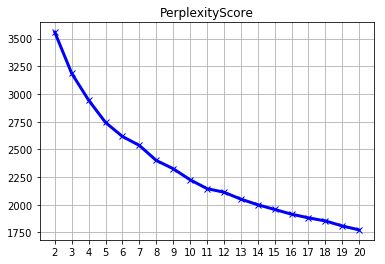

In [30]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [31]:
perplexity

[3557.615966796875,
 3185.9775390625,
 2944.277099609375,
 2742.6923828125,
 2616.28076171875,
 2535.360107421875,
 2399.819580078125,
 2325.294677734375,
 2225.538330078125,
 2145.45068359375,
 2112.965576171875,
 2050.5146484375,
 1999.893798828125,
 1957.251953125,
 1914.6068115234375,
 1881.270263671875,
 1853.5712890625,
 1808.1280517578125,
 1772.3289794921875]

### select the best model

In [32]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.2: 1, 0.3: 1, 0.4: 1, 0.5: 1, 0.6: 5, 0.7: 10}
d_stheta: {0.1: 1, 0.2: 1, 0.3: 1, 0.4: 2, 0.5: 3, 0.6: 6, 0.7: 5}


In [33]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

20


### print top words for each topics

In [34]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['сказать' 'финансы' 'минфин' 'владимир_путин' 'подчеркнуть' 'добавить'
 'вицепремьер' 'триллион' 'премьерминистр' 'расход']
topic_1: ['суд' 'юкос' 'дело' 'иск' 'подать' 'претензия' 'арбитражный' 'аукцион'
 'судебный' 'признать']
topic_2: ['сеть' 'продукция' 'товар' 'продукт' 'торговый' 'производитель' 'магазин'
 'сотовый' 'запрет' 'импорт']
topic_3: ['услуга' 'карта' 'тариф' 'фас' 'оператор' 'ржд' 'почта' 'клиент'
 'платёжный' 'антимонопольный']
topic_4: ['кредит' 'долг' 'задолженность' 'облигация' 'ставка' 'кредитный'
 'кредитор' 'мвф' 'помощь' 'погашение']
topic_5: ['украина' 'пенсионный' 'украинский' 'пенсия' 'киев' 'нафтогаз' 'гривна'
 'накопление' 'крым' 'нафтогаза']
topic_6: ['цб' 'вклад' 'банковский' 'кредитный' 'сбербанк' 'лицензия' 'центробанк'
 'капитал' 'регулятор' 'операция']
topic_7: ['человек' 'место' 'зарплата' 'россиянин' 'рейтинг' 'население'
 'исследование' 'доход' 'труд' 'средний']
topic_8: ['the' 'bank' 'британский' 'фунт' 'сотрудник' 'корпорация'
 'велико

### get topics-docs matrix

shape theta: (20, 71942)


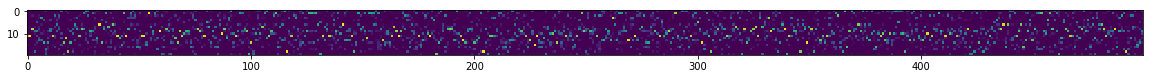

In [35]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [36]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
58000,0.000000,0.0,0.000000,0.0,0.079376,0.0,0.0,0.0,0.038968,0.0,0.000000,0.055445,0.652710,0.000000,0.000000,0.0,0.0,0.0,0.0,0.173502
58001,0.000000,0.0,0.617446,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.382554,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
58002,0.474194,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.479551,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.046255
58003,0.000000,0.0,0.000000,0.0,0.366689,0.0,0.0,0.0,0.000000,0.0,0.000000,0.520274,0.113037,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
58004,0.100216,0.0,0.382805,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.135849,0.000000,0.000000,0.331888,0.049241,0.0,0.0,0.0,0.0,0.000000


## DataViz

In [37]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.044917,0.165693,0.000000,0.0,0.404930,0.0,0.149012,...,0.000000,0.0,0.000000,0.046110,0.0,0.0,0.0,0.000000,0.000000,0.189340
1,1,1999,10,0.000000,0.000000,0.311591,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.012275,0.649282,0.0,0.0,0.0,0.026853,0.000000,0.000000
2,2,1999,10,0.152400,0.000000,0.000000,0.0,0.000000,0.0,0.085924,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.456851
3,3,1999,10,0.000000,0.020178,0.000000,0.0,0.254007,0.0,0.000000,...,0.138986,0.0,0.442521,0.000000,0.0,0.0,0.0,0.144307,0.000000,0.000000
4,4,1999,10,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.333627,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000214,0.147850


In [38]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (228, 20)


topic_0    topic_1   topic_2   topic_3    topic_4   topic_5  \
year month                                                                  
1999 8       0.564626   0.206366  0.177660  0.035670   0.591775  0.000000   
     9       9.258154   4.879057  1.202960  1.629356   5.405372  0.732880   
     10      8.977428   8.161783  4.975061  3.946555   8.140151  1.803937   
     11     12.619608  11.187172  8.588631  4.370636  10.308842  3.071943   
     12      7.633865   7.951242  4.084478  5.184410   7.978260  1.130237   

             topic_6   topic_7    topic_8   topic_9   topic_10  topic_11  \
year month                                                                 
1999 8      0.008874  0.000000   0.080469  0.000000   0.083864  0.000000   
     9      2.908502  1.457861   4.117820  0.982015   3.471934  4.579579   
     10     4.866539  3.749151  12.157893  2.459137  13.608975  4.870541   
     11     3.633021  2.848051   8.189355  1.989823  10.649523  1.847576   
     12     3.421335  0.961044   5.507011  0.923885   3.694526  5.088269   

            topic_12   topic_13  topic_14  topic_15  topic_16  topic_17  \
year month                                                                
1999 8      0.000000   0.476335  0.114383  0.051526  0.432240  0.000000   
     9      1.411970   8.000705  1.010459  1.632060  1.945212  3.773577   
     10     5.711818  11.249212  4.213326  5.115235  3.314962  3.746012   
     11     4.641692  19.172735  5.191125  4.047565  4.504980  4.737111   
     12     1.926688   8.847294  3.270356  1.193030  0.350603  2.681756   

            topic_18  topic_19  
year month                      
1999 8      0.072365  0.103848  
     9      1.526118  6.074408  
     10     2.920014  7.012270  
     11     1.549980  9.850633  
     12     1.158139  6.013572

### straightforward matrix heatmap

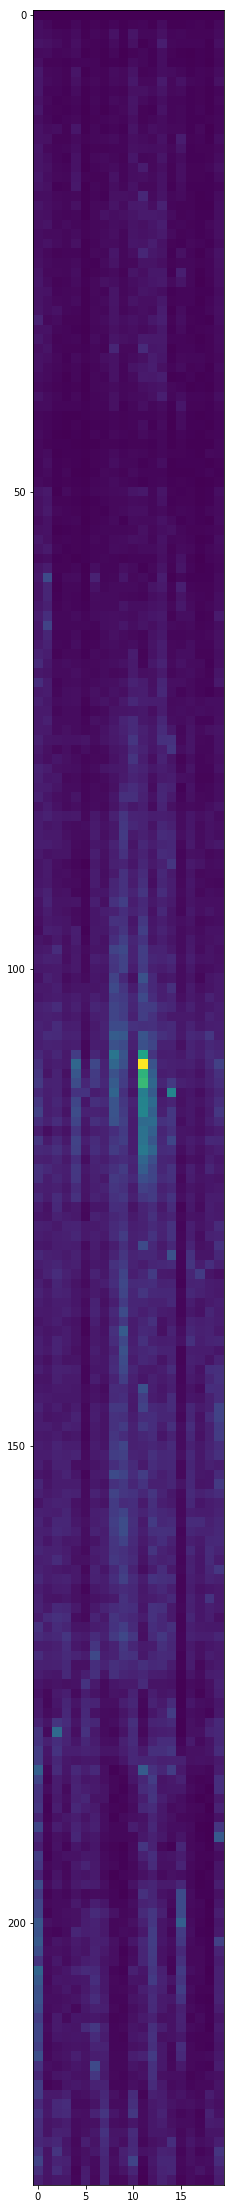

In [39]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [40]:
import pygal
from IPython.display import SVG, HTML

In [41]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [ ]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [43]:
line_chart.render_to_file(f'data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg')

## joypy

In [44]:
import joypy # !pip install joypy

In [45]:
print(joined.shape)
joined.head()

(71951, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.044917,0.165693,0.000000,0.0,0.404930,0.0,0.149012,...,0.000000,0.0,0.000000,0.046110,0.0,0.0,0.0,0.000000,0.000000,0.189340
1,1,1999,10,0.000000,0.000000,0.311591,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.012275,0.649282,0.0,0.0,0.0,0.026853,0.000000,0.000000
2,2,1999,10,0.152400,0.000000,0.000000,0.0,0.000000,0.0,0.085924,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.456851
3,3,1999,10,0.000000,0.020178,0.000000,0.0,0.254007,0.0,0.000000,...,0.138986,0.0,0.442521,0.000000,0.0,0.0,0.0,0.144307,0.000000,0.000000
4,4,1999,10,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.333627,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000214,0.147850


In [46]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,year_month
0,0,0,1999,10,0.044917,0.165693,0.000000,0.0,0.404930,0.0,...,0.0,0.000000,0.046110,0.0,0.0,0.0,0.000000,0.000000,0.189340,1999-10-01
1,1,1,1999,10,0.000000,0.000000,0.311591,0.0,0.000000,0.0,...,0.0,0.012275,0.649282,0.0,0.0,0.0,0.026853,0.000000,0.000000,1999-10-01
2,2,2,1999,10,0.152400,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.456851,1999-10-01
3,3,3,1999,10,0.000000,0.020178,0.000000,0.0,0.254007,0.0,...,0.0,0.442521,0.000000,0.0,0.0,0.0,0.144307,0.000000,0.000000,1999-10-01
4,4,4,1999,10,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000214,0.147850,1999-10-01


In [47]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(1726824, 3)


,year_month,topic,text
0,1999-10-01,index,0.0
1,1999-10-01,index,1.0
2,1999-10-01,index,2.0
3,1999-10-01,index,3.0
4,1999-10-01,index,4.0


In [48]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(1439020, 3)


topic_3     71951
topic_11    71951
topic_8     71951
topic_19    71951
topic_0     71951
topic_10    71951
topic_4     71951
topic_17    71951
topic_14    71951
topic_1     71951
topic_18    71951
topic_16    71951
topic_13    71951
topic_2     71951
topic_15    71951
topic_7     71951
topic_5     71951
topic_9     71951
topic_12    71951
topic_6     71951
Name: topic, dtype: int64

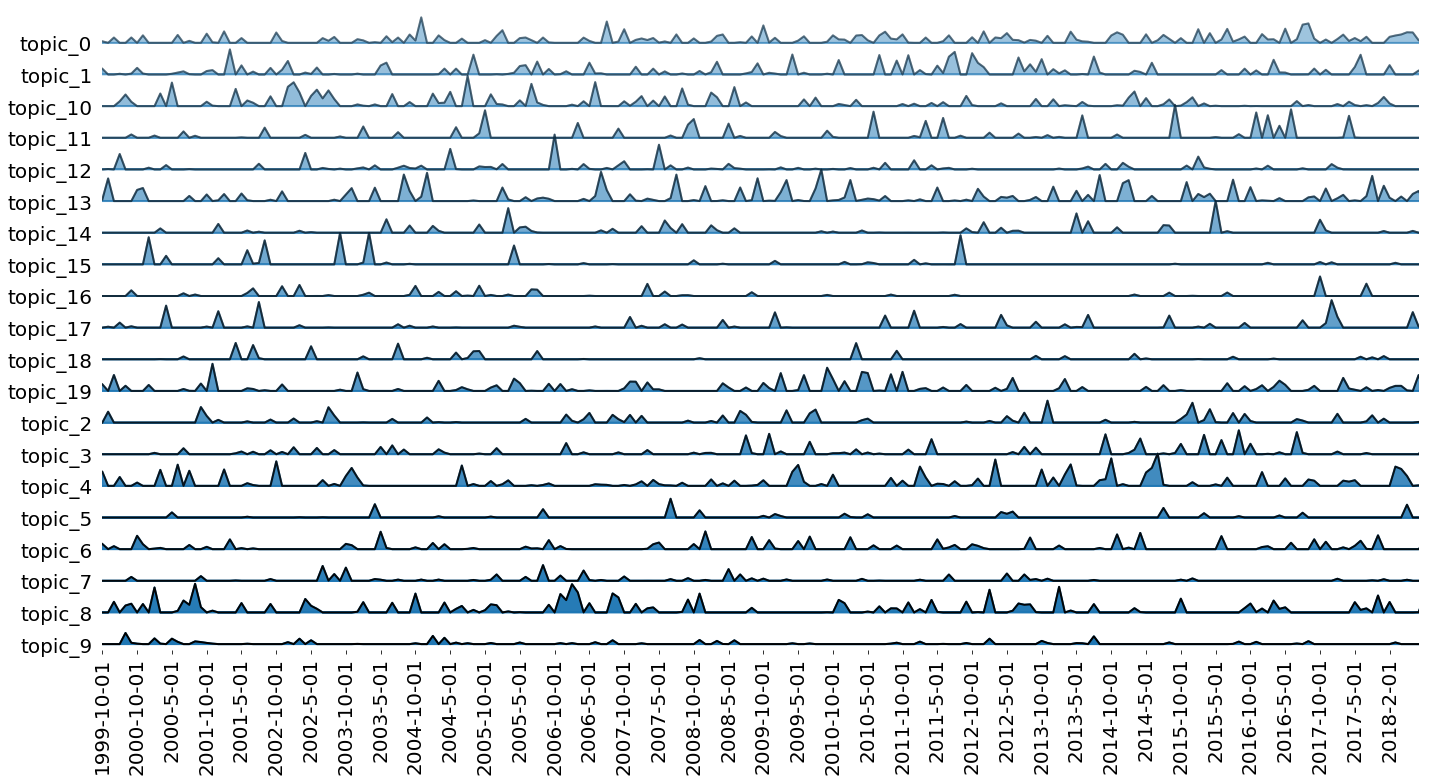

In [49]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [50]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")